# Setup & imports

In [1]:
!pip -q install "gymnasium[atari,accept-rom-license]" stable-baselines3[extra] ale-py shimmy

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed

In [3]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: False


In [4]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)
print("ALE registered ✅")

ALE registered ✅


In [5]:
ENV_ID = "ALE/Tennis-v5"
TOTAL_TIMESTEPS = 300_000
EVAL_EPISODES = 20
SEEDS = [0, 1, 2]

LOG_DIR = "./logs_tennis"
MODELS_DIR = "./models_tennis"
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

In [6]:
def make_env(env_id=ENV_ID, seed=0, rank=0):
    def _init():
        gym.register_envs(ale_py)
        env = gym.make(env_id)
        env = Monitor(env)
        env = AtariWrapper(env)
        env.reset(seed=seed + rank)
        env.action_space.seed(seed + rank)
        return env
    return _init

def make_vec_env_dqn(seed=0, n_stack=4):
    set_random_seed(seed)
    venv = DummyVecEnv([make_env(seed=seed, rank=0)])
    venv = VecFrameStack(venv, n_stack=n_stack)
    return venv

def make_vec_env_ppo(seed=0, n_envs=8, n_stack=4):
    set_random_seed(seed)
    venv = SubprocVecEnv([make_env(seed=seed, rank=i) for i in range(n_envs)])
    venv = VecFrameStack(venv, n_stack=n_stack)
    return venv

In [7]:
import time, gc
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

class EvalCallbackSimple(BaseCallback):
    def __init__(self, eval_env, eval_freq=100_000, n_eval_episodes=3, seed=0, verbose=0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.seed = seed
        self.history = []

    def _on_step(self) -> bool:
        if self.num_timesteps > 0 and self.n_calls % self.eval_freq == 0:
            print(f"[EVAL] t={self.num_timesteps} | seed={self.seed}")
            mean_r, std_r = evaluate_policy(
                self.model, self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                deterministic=True,
            )
            self.history.append({
                "timesteps": self.num_timesteps,
                "mean_reward": float(mean_r),
                "std_reward": float(std_r),
                "seed": self.seed
            })
        return True


In [8]:
from stable_baselines3 import DQN, PPO 

def dqn_kwargs(seed):
    return dict(
        learning_rate=1e-4,
        buffer_size=200_000,
        learning_starts=20_000,
        batch_size=32,
        gamma=0.99,
        train_freq=4,
        gradient_steps=1,
        target_update_interval=10_000,
        exploration_fraction=0.20,
        exploration_final_eps=0.01,
        verbose=0,
        seed=seed,
        device="cuda",
    )

def ppo_kwargs(seed, n_envs):
    return dict(
        learning_rate=2.5e-4,
        n_steps=128,
        batch_size=256, 
        n_epochs=4,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.1,
        ent_coef=0.01,
        vf_coef=0.5,
        max_grad_norm=0.5,
        verbose=0,
        seed=seed,
        device="cuda", 
    )


In [9]:
def train_dqn(seed=0):
    print("\n" + "="*50)
    print(f"[START] DQN | seed {seed}")
    print("="*50)

    t_seed = time.time()

    env = make_vec_env_dqn(seed=seed)
    eval_env = make_vec_env_dqn(seed=seed+100)

    model = DQN("CnnPolicy", env, **dqn_kwargs(seed))
    cb = EvalCallbackSimple(eval_env, eval_freq=50_000, n_eval_episodes=3, seed=seed)

    t0 = time.time()
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb, progress_bar=True)
    learn_time = time.time() - t0
    print(f"[TIME] learn = {learn_time/60:.2f} min")

    t1 = time.time()
    final_mean, final_std = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
    eval_time = time.time() - t1
    print(f"[TIME] final eval = {eval_time:.1f} s")

    # cleanup
    env.close(); eval_env.close()
    del model, env, eval_env
    gc.collect()

    seed_time = time.time() - t_seed
    print(f"[END] DQN | seed {seed} | total = {seed_time/60:.2f} min")

    return cb.history, {
        "algo":"DQN","seed":seed,
        "final_mean":float(final_mean),"final_std":float(final_std),
        "learn_time_s":float(learn_time),"eval_time_s":float(eval_time),
        "seed_time_s":float(seed_time),
    }



In [ ]:
def train_ppo(seed=0, n_envs=8):
    print("\n" + "="*50)
    print(f"[START] PPO | seed {seed} | n_envs={n_envs}")
    print("="*50)

    t_seed = time.time()

    env = make_vec_env_ppo(seed=seed, n_envs=n_envs)
    eval_env = make_vec_env_dqn(seed=seed+100)  # eval en 1 env = plus simple/standard

    model = PPO("CnnPolicy", env, **ppo_kwargs(seed, n_envs))
    cb = EvalCallbackSimple(eval_env, eval_freq=50_000, n_eval_episodes=3, seed=seed)

    t0 = time.time()
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb, progress_bar=True)
    learn_time = time.time() - t0
    print(f"[TIME] learn = {learn_time/60:.2f} min")

    t1 = time.time()
    final_mean, final_std = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
    eval_time = time.time() - t1
    print(f"[TIME] final eval = {eval_time:.1f} s")

    # cleanup
    env.close(); eval_env.close()
    del model, env, eval_env
    gc.collect()

    seed_time = time.time() - t_seed
    print(f"[END] PPO | seed {seed} | total = {seed_time/60:.2f} min")

    return cb.history, {
        "algo":"PPO","seed":seed,
        "final_mean":float(final_mean),"final_std":float(final_std),
        "learn_time_s":float(learn_time),"eval_time_s":float(eval_time),
        "seed_time_s":float(seed_time),
    }


In [11]:
import pandas as pd

SEEDS = [0,1,2]

all_hist = []
summary = []

for seed in SEEDS:
    h, s = train_ppo(seed, n_envs=8)
    all_hist += [dict(**row, algo="PPO") for row in h]
    summary.append(s)


hist_df = pd.DataFrame(all_hist)
sum_df = pd.DataFrame(summary)

final_table = (
    sum_df.groupby("algo")
    .agg(final_mean_avg=("final_mean","mean"),
         final_mean_std=("final_mean","std"),
         runs=("seed","count"),
         learn_time_min=("learn_time_s", lambda x: x.mean()/60))
    .reset_index()
)

sum_df, final_table



[START] PPO | seed 0 | n_envs=8


Output()

[TIME] learn = 14.35 min
[TIME] final eval = 519.8 s
[END] PPO | seed 0 | total = 23.38 min

[START] PPO | seed 1 | n_envs=8


Output()

[TIME] learn = 14.19 min
[TIME] final eval = 538.3 s
[END] PPO | seed 1 | total = 23.52 min

[START] PPO | seed 2 | n_envs=8


Output()

[TIME] learn = 14.33 min
[TIME] final eval = 529.5 s
[END] PPO | seed 2 | total = 23.44 min


(  algo  seed  final_mean  final_std  learn_time_s  eval_time_s  seed_time_s
 0  PPO     0        -1.0        0.0    861.191553   519.817437  1402.684401
 1  PPO     1        -1.0        0.0    851.346390   538.259212  1411.092105
 2  PPO     2        -1.0        0.0    859.742607   529.549992  1406.403417,
   algo  final_mean_avg  final_mean_std  runs  learn_time_min
 0  PPO            -1.0             0.0     3       14.290447)

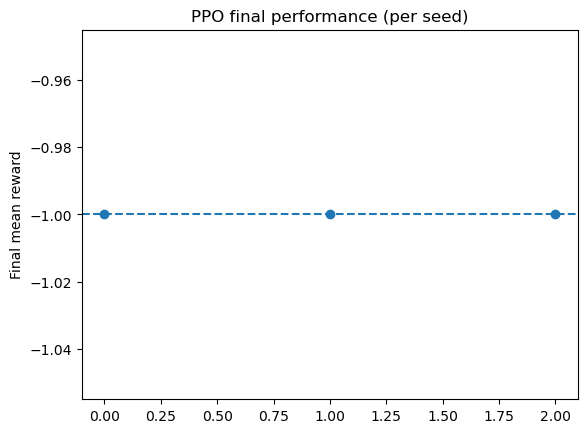

In [18]:
plt.scatter(sum_df["seed"], sum_df["final_mean"])
plt.axhline(sum_df["final_mean"].mean(), linestyle="--")
plt.title("PPO final performance (per seed)")
plt.ylabel("Final mean reward")
plt.show()
